# Convolutional Neural Networks

A convolutional neural network (CNN) is a neural network in which the linear maps that are used in each layer are convolutional filters. Using $h_{\ell k}$ to denote the filter coefficients used at Layer $\ell$, a CNN is defined by the recursion

\begin{equation}\tag{1}   
   \mathbf{x}_0 
      = \mathbf{x}, \quad      
   \mathbf{x}_\ell 
      = \sigma \Big(\, \mathbf{z}_\ell       \,\Big)
      = \sigma \left(\, \sum_{k=0}^K h_{lk}\,\mathcal{S}^k \mathbf{x}  \, \right)  ,\quad
   \mathbf{x}_L 
      = \mathbf{\phi}(\mathbf{x}; \mathcal{H}).
\end{equation}

In (1) we use $\mathbf{\phi}(\mathbf{x}; \mathcal{H})$ to denote the output of the CNN, with $\mathcal{H}=[h_{11},\ldots,h_{KL}]$ being a tensor that groups all of the filter coefficients that make up the layers of the CNN. 

Notice that since convolutions are linear operations, a CNN is a particular case of a standard neural network. This being true, a CNN is still a composition of layers each of which is itself the composition of a linear map with a pointwise nonlinearity. The only difference is that instead of generic linear maps, layers use (linear) convolutions.n When we want to highlight that a neural network is \emph{not} convolutional, we call it a fully connected neural network (FCNN).

An important observation to make is that since the nonlinear operations that are used at each layer are pointwise, the CNN inherits the shift invariance of convolutions. Locality and shift invariance are the motivations for introducing convolutions. CNNs inherit these two properties. We can then think of CNNs as generalizations of convolutions. We can, in fact, argue that CNNs are minor variations of convolutions. They are nonlinear operators designed to stay as close as possible to linear convolutional filters. We just add pointwise nonlinearities. 

Do notice that we are not saying that this minor architectural variation is irrelevant. Quite the contrary, it has a major effect on the practical performance of CNNs as we explore in this lab.

# TASK 1

Program a class to implement CNNs. This class receives as initialization parameters the number of layers $L$ and the number of taps of the filters of each layer. The number of taps per layer is given as a vector with $L$ entries. Endow the class with a forward methods that takes a vector $\mathbf{x}$ as an input and works through the recursion in (1) to return the CNN output $\mathbf{\phi}(\mathbf{x}; \mathcal{H})$. Use tanh nonlinearities in all layers.

In [1]:
# import necessary packages
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch
import numpy as np
import random
# 
np.random.seed(1)
torch.manual_seed(1)
random.seed(1)


In [2]:
# Define the convolutional function as in LAB2A
def convolution_1D(signal,filter):
    taps = filter.shape[-1]
    z = torch.zeros(signal.shape)
    for k in range(taps):
        z = z + signal * filter[k]
        signal = signal.roll(1)
        signal[:,0] = 0
    return z

# Define the convolutional layer that inherits from nn.Module
# and implements (1) using convolution_1D

class Convolutional_Layer(nn.Module):
    def __init__(self,taps):
        super().__init__()
        self.filter = torch.nn.Parameter(torch.ones(taps))

    def forward(self,x):
        return convolution_1D(x,self.filter)

# Define the CNN, which also inherits from nn.Module
# and has L layers, where each layer instantiates the convolutional_layer class

class CNN(nn.Module):
    def __init__(self, L,taps):
        '''
        inputs:
            L (int): number of layers
            taps (list[int]): list with number of taps for each layer
        '''
        super().__init__()
        self.L = L
        assert len(taps) == L, f"There are {L} layers, but taps is a vector of length {len(taps)}"
        self.conv_layers = []
        for i in range(L):
            self.conv_layers.append(Convolutional_Layer(taps[i]))


    def forward(self, x):
        for i in range(self.L):
            # compute the convolution
            x = self.conv_layers[i](x)
            if i != self.L-1:
                x = torch.tanh(x)
        return x

# Multiple-Input-Multiple-Output (MIMO) Filters

Multiple input (MI) features can be processed with separate filterbanks to produce multiple output (MO) features. In these MIMO filters the input is a matrix $\mathbf{x}$ and the output is another matrix matrix $\mathbf{y}$. The MIMO filter coefficients are matrices $\mathbf{H}_k$ and the MIMO filter itself is a generalization of \eqref{eqn_filterbank_vector} in which the matrix $\mathbf{H}_k$ replaces the vector $\mathbf{H}_k$,

\begin{equation}\tag{2}  
   \mathbf{y} = \sum_{k=0}^K \mathcal{S}^k \mathbf{x} \mathbf{H}_k .
\end{equation}

In (2), the input feature matrix $\mathbf{x}$ has dimension $N \times F$ and the output feature matrix $\mathbf{y}$ has dimension $N \times G$. This means that each of the $F$ columns of $\mathbf{x}$ represents a separate input feature whereas each of the $G$ columns of $\mathbf{y}$ represents an output feature. To match dimensions, the filter coefficient matrices $\mathbf{H}_k$ must be of dimension $F \times G$.

# TASK 2

Program a class that implements a MIMO filter. This class has as attributes the length of the filter $K$ and the dimensions $F$ and $G$ of the filter coefficients. The filter coefficients themselves are also an attribute of the class. Endow the class with a forward method that takes an input feature $\mathbf{x}$ and produces the corresponding output feature $\mathbf{y}$.

In [3]:
# Define the function that implementss a MIMO convolution
def MIMO_convolution_1D(signal,filter):
    taps = filter.shape[0]
    G = filter.shape[1]
    N = signal.shape[-1]
    z = torch.zeros((G,N))
    for k in range(taps):
        z = z + torch.matmul(filter[k] , signal)
        signal = signal.roll(1,)
        signal[:,0] = 0
    return z

# Define the convolutional layer class that inherits from nn.module

class MIMO_convolutional_layer(nn.Module):
    def __init__(self,F,G,K):
        '''
        inputs:
            G(int): Number of output features
            F(int): Number of input features
            K(int): Number of filter taps
        '''
        super().__init__()
        self.filter = torch.nn.Parameter(torch.empty(K,G,F))
        nn.init.xavier_normal_(self.filter)
    def forward(self,x):
        return MIMO_convolution_1D(x,self.filter)



# Real Convolutional Neural Networks

The MIMO filters of the last Section can be used to define MIMO CNNs. A MIMO CNN is a neural network in which each of the layers is the composition of a MIMO convolutional filter with a pointwise nonlinearity. If at each layer we denote filter coefficients as $\mathbf{H}_{\ell k}$, the MIMO CNN is given by the recursion

\begin{equation}  
   \mathbf{x}_0 
      = \mathbf{x}, \quad      
   \mathbf{x}_\ell 
      = \sigma \Big(\, \mathbf{z}_\ell       \,\Big)
      = \sigma \left(\, \sum_{k=0}^{K_\ell} \mathcal{S}^k \mathbf{x} \mathbf{H}_{\ell k}  \, \right)  ,\quad
   \mathbf{x}_L 
      = \mathbf{\phi}(\mathbf{x}; \mathcal{H}).
\end{equation}

Thus, we have a composition of layers each of which is itself the composition of a MIMO convolutional filter with a pointwise nonlinearity. 

The CNN of the first Section was introduced for didactic purposes because almost all CNNs used in practice are MIMO CNNs -- hence, the title of this section. For that reason we never call them MIMO CNNs, we just call them CNNs. 

# Convolutional Neural Network Specification

To specify a CNN we need to specify the number of layers $L$ and the characteristics of the filers that are used at each layer. The latter are the number of filter taps $K_\ell$ and the number of features $F_\ell$ at the output of the layer. The number of features $F_0$ must match the number of features at the input and the number of features $F_L$ must match the number of features at the output. Observe that the number of features at the output of Layer $(\ell-1)$ determines the number of features at the input of Layer $\ell$. Then, the filter coefficients at Layer $\ell$ are of dimension $F_{\ell-1} \times F_\ell$.

# TASK 3
Program a class that implements a CNN with $L$ layers. This class receives as initialization parameters a CNN specification consisting of the number of layers $L$ and vectors $[K_1, \ldots, K_L]$ and $[F_0, F_1, \ldots, F_L]$ containing the number of taps and the number of features of each layer. 

Endow the class with a forward method that takes an input feature $\mathbf{x}$ and produces the corresponding output feature $\mathbf{\phi}(\mathbf{x}; \mathcal{H})$.

In [4]:
# Define the CNN

class MIMO_CNN(nn.Module):
    def __init__(self, L,taps,features):
        '''
        inputs:
            L (int): number of layers
            taps (list[int]): list with number of taps for each layer [K1, ..., KL]
            features: list with number of features of each layer [F0, ..., FL]
        '''
        super().__init__()
        self.L = L
        assert len(taps) == L, f"There are {L} layers, but taps is a vector of length {len(taps)}"
        assert len(features) == L+1, f"There are {L} layers, but features is a vector of length {len(features)} (There has to be L+1 features)"        
        self.layers = nn.ModuleList()
        for i in range(L):
            self.layers.append(MIMO_convolutional_layer(F=features[i],G=features[i+1],K=taps[i]))

    def forward(self, x):
        for i in range(self.L):
            x = self.layers[i](x)
            if i != self.L-1:
                x = torch.tanh(x)
        return x

# Audio Processing with Convolutional Neural Networks

We have prepared a dataset similar to the one we used in Lab 2A. We ask that you process it with a CNN. 


# TASK 4

Load audio data from the link provided in the course site, and unzip it. This file contains a pytorch tensor with Q = 300 pairs of audio recordings $(\mathbf{x}_q, \mathbf{y}_q)$. Split the dataset into training and testing sets, keep 50 samples for testing. Train a CNN to remove the background noise. This CNN has 2 layers, the numbers of features per layer are $[1,5,1]$ and the filter lengths are $[40,40]$. Use a learning rate of 0.5, batch size of 32 and train for 20 epochs. Evaluate the train and test loss (use L1 loss as in lab 2A).

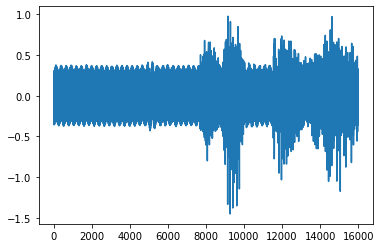

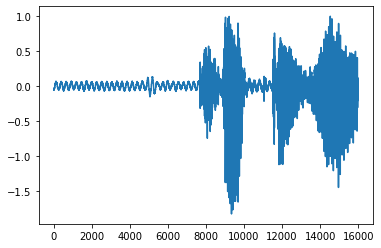

In [5]:
import matplotlib.pyplot as plt
from IPython.display import Audio

dataB = torch.load('dataB.pt')
sample_rate = 16000

# Data consist of a list of 1500 (x,y) tuples.

# Take one sample and separate x and y
data_0 = dataB[0]
x_0 = data_0[0]
y_0 = data_0[1]


# Noisy signal plot and play
plt.plot(x_0[0])
plt.show()
display(Audio(x_0[0],rate=sample_rate))

# Original signal plot and play
plt.plot(y_0[0])
plt.show()
display(Audio(y_0,rate=sample_rate))

# Split into train and test

test_size = 50
train_size = len(dataB) - test_size

test_set_B, train_set_B =  torch.utils.data.random_split(dataB, [test_size, train_size])

In [6]:
def evaluate(dataloader, estimator):
    loss = 0
    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            yHat = estimator.forward(x_batch)
            loss += torch.mean((yHat-y_batch)**2)
    numBatchs = len(dataloader)
    loss /= numBatchs
    return loss.item()

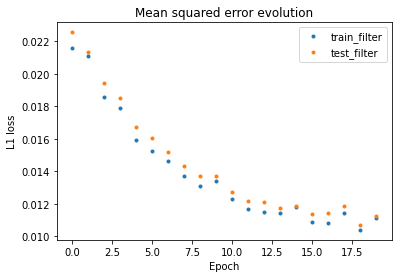

In [7]:
# SAME TRAINING LOOP as in previous lab BUY WITH MIMO_CNN AS ESTIMATOR
L = 2
taps = [40, 40]
features = [1,5,1]
estimator = MIMO_CNN(L=L,taps=taps,features=features)
lr=0.5
batch_size = 32

optimizer = optim.SGD(estimator.parameters(), lr=lr)
loss_L1 = nn.L1Loss()


# Instantiate Data Loaders
train_loader_CL = DataLoader(
    train_set_B,
    batch_size=batch_size,
    shuffle=True,
)

test_loader_CL = DataLoader(
    test_set_B,
    batch_size=batch_size,
    shuffle=False,
)

loss_evolution = []
loss_evolution_test = []


# Training loop

n_epochs = 20
# Iterate n_epochs times over the whole dataset.

for ep in range(n_epochs):
    i=0
    #iterate over all batches in the dataset
    for x_batch, y_batch in train_loader_CL:
        i+=1
        # set gradients to zero
        estimator.zero_grad()
       
        # Compute predictions
        yHat = estimator.forward(x_batch)

        # Compute loss
        loss = loss_L1(yHat,y_batch)
        loss.backward()

        # Update parameters
        optimizer.step()
    epoch_loss_filter = evaluate(train_loader_CL, estimator)    
    loss_evolution.append(epoch_loss_filter)
    
    lossTest_filter = evaluate(test_loader_CL, estimator)  
    loss_evolution_test.append(lossTest_filter)
    print(f'epoch {ep+1} / {n_epochs} loss {lossTest_filter}',end='\r')
# Plot results
_ = plt.plot(loss_evolution, ".", label="train_filter")
_ = plt.title("Mean squared error evolution")
_ = plt.xlabel("Epoch")
_ = plt.ylabel("L1 loss")
_ = plt.plot(loss_evolution_test, ".", label="test_filter")
_ = plt.legend()


In [8]:
# Listen to the samples

# (change to try other audios)
nmbr_example = 1


x_batch, y_batch = next(iter(test_loader_CL))
sample_x, sample_y = x_batch[nmbr_example], y_batch[nmbr_example]
predicted_y = estimator(sample_x).detach()[0]

print(f'Original Audio')
display(Audio(sample_y, rate=sample_rate))

print(f'Noisy Audio')
display(Audio(sample_x, rate=sample_rate))

print(f'Audio recovered with filter')
display(Audio(predicted_y, rate=sample_rate))

Original Audio


Noisy Audio


Audio recovered with filter
